# Временные ряды 5. Поиск аномалий и особенные случаи обработки  

Временные ряды - процесс, который идет шаг за шагом. Порядок постоянен или предсказуем. Однако, иногда что-то идет не так. Котенок не  бегает за бантиком. Вопрос - это только сегодня или теперь так будет всегда? Если всегда, то идем менять модель (кот вырос). Если только сейчас, то это аномалия. Аномалии интересны, но опасны.

Попробуем разобраться аномалиями. Вспомним пример аварии в потреблении энергии и попробуем его узнать автоматически.      


## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace = True)
data.drop('Time',axis = 1, inplace = True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Общий вид изменения ключевого свойства ряда приведен на рис.1.

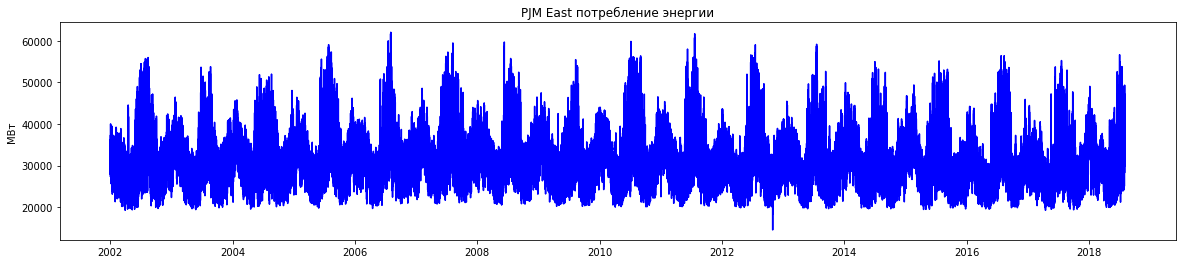

In [3]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

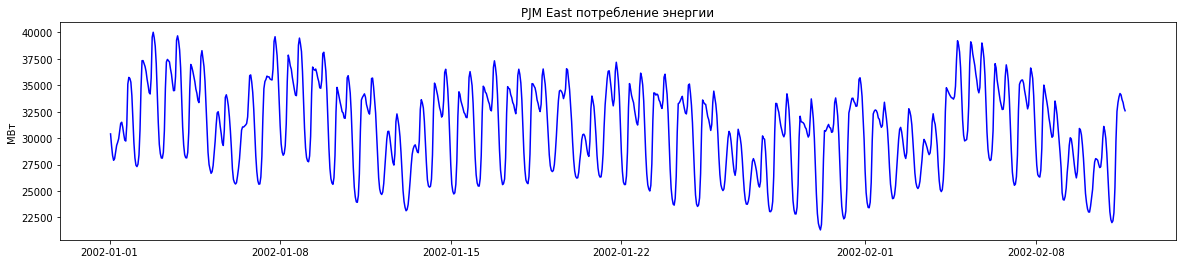

In [4]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index[:1000], data['PJME_MW'].iloc[:1000], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

Выделим тренд и циклы.
1) Тренд:
    - переписывем модель в точки с координатами х1=i-номер измерения, y=значению потребления
    - строим модель y = w1*x1+w0

32079.773047450024 -0.009426799102882006


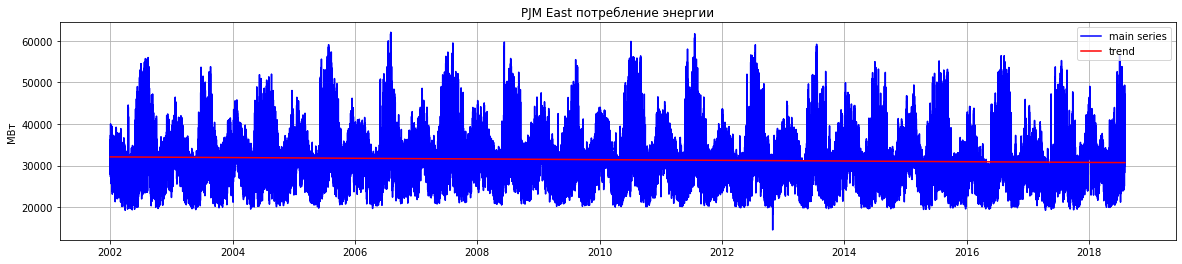

In [5]:
from sklearn.linear_model import LinearRegression

y= data['PJME_MW'].values
x1 = np.array(range(data.shape[0]))

Lin_mod = LinearRegression()
Lin_mod.fit(x1.reshape(-1, 1),y.reshape(-1, 1))

W1 =Lin_mod.coef_[0,0]
W0 =y.mean()
print(W0,W1)

plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' , label ='main series')
plt.plot( data.index[[0,-1]], [W0+W1*x1[0] , W0+W1*x1[-1]], 'r',label='trend' )
plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

Проверим с помощью теста Фишера гипотезу о равенстве коэффициентов 0. Для этого воспользуемся пакетом statsmodels (там есть очень удобный метод summary)

In [6]:
X2 = sm.add_constant(x1)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     546.5
Date:                Sat, 18 Jul 2020   Prob (F-statistic):          1.20e-120
Time:                        16:42:17   Log-Likelihood:            -1.4815e+06
No. Observations:              145374   AIC:                         2.963e+06
Df Residuals:                  145372   BIC:                         2.963e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.276e+04     33.844    968.113      0.0

Убираем тренд и переходим к поиску циклов.

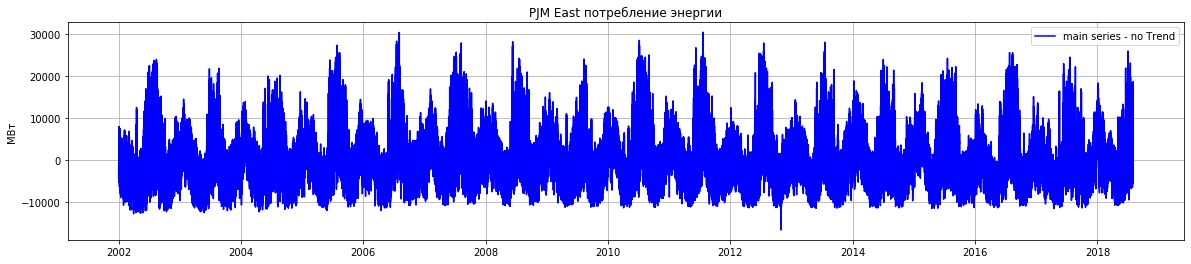

In [7]:
y_no_trend = y - W0-W1*x1

plt.figure(figsize =(20,4))
plt.plot( data.index,y_no_trend, 'b' , label ='main series - no Trend')

plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

In [8]:
X2 = sm.add_constant(x1)
est = sm.OLS(y_no_trend, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                -2.346e-11
Date:                Sat, 18 Jul 2020   Prob (F-statistic):               1.00
Time:                        16:42:17   Log-Likelihood:            -1.4815e+06
No. Observations:              145374   AIC:                         2.963e+06
Df Residuals:                  145372   BIC:                         2.963e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.2010     33.844     20.246      0.0

2) Знаем из ACF, что цикл где-то 12 месяцев(52-53 недели, 365-366 дней). В часовом исполнении это будет 365(+/-1)*24  . Проверяем отклонения для этих данных. 

In [9]:
#delta_range = range(365*24,366*24)
#stdi=[]
#for delta in delta_range:
#    stdi.append(np.std(y_no_trend[delta:]-y_no_trend[:-delta]))
#tab_=pd.DataFrame(data=stdi,index=delta_range)
season = 8760#np.argmin(tab_[0])
print('длина годового цикла = ', 8760)#np.argmin(tab_[0])   ) 


длина годового цикла =  8760


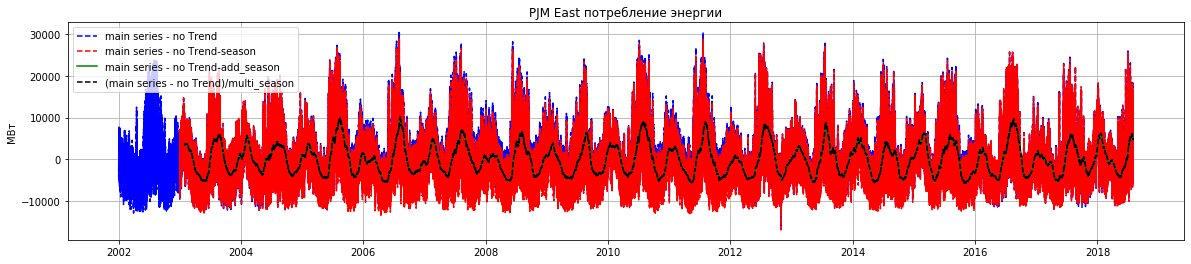

In [10]:
# снимаем составляющую из годового сдвига (вычитаем среднюю по длине цикла из ACF)
# без тренда
y_no_trend_no_season = pd.DataFrame(data=y_no_trend, index =data.index, columns =['no_trend'])
# тренд
y_no_trend_no_season['trend'] = W0-W1*x1
# сезонные аддитивные сдвиги
y_no_trend_no_season['no_season'] = y_no_trend_no_season['no_trend']-y_no_trend_no_season['no_trend'].rolling(season).mean()

# определяем потенциальную дилну сезонного цикла в месяцах цикла (число дней месяца умножим на число часов = длина месяца в часах)
delta_range = range(27*24,31*24)

#подбор по параметру лучшей средней абсолютной разницы
s_i=[]
for delta in delta_range:
    s_i.append(np.mean(y_no_trend_no_season['no_season']-y_no_trend_no_season['no_season'].rolling(delta).mean()))
tab_f=pd.DataFrame(data=s_i,index=delta_range,columns=['add'])
season_f = np.argmin(np.abs(tab_f['add']))

#подбор для мультипликативной модели (средний индекс должет быть 1)
delta_range = range(27*24,31*24)
s_i=[]
for delta in delta_range:
    s_i.append(np.mean(y_no_trend_no_season['no_season']/y_no_trend_no_season['no_season'].rolling(delta).mean()))
tab_f['multi_season']=np.array(s_i)
season_fm = np.argmin(np.abs(tab_f['multi_season']-1))

# порисуем
plt.figure(figsize =(20,4))
plt.plot( data.index,y_no_trend_no_season['no_trend'], '--b' , label ='main series - no Trend')
plt.plot( data.index,y_no_trend_no_season['no_season'], '--r' , label ='main series - no Trend-season')
plt.plot( data.index,y_no_trend_no_season['no_season'].rolling(season_f).mean(), 'g' , label ='main series - no Trend-add_season')
plt.plot( data.index,y_no_trend_no_season['no_season'].rolling(season_fm).mean(), '--k' , label ='(main series - no Trend)/multi_season')


plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

Построили тренд и варианты сезонной модели. Однако похоже, что аддитивный сезон не рабочий. Берем мультипликативный сезон и покажем, какие варианты лучшие (среднее частное ближе к 1)

In [11]:
tab_f.loc[np.abs(tab_f['multi_season']-1)<0.1].head(10)

,add,multi_season
669,0.849977,0.946202
683,1.015687,0.990550
717,0.934652,0.930987


In [12]:
tab_f.loc[np.abs(tab_f['add'])<0.2].head(10)

,add,multi_season


лучший вариант по мультипликативному сезону: 683 часа

In [13]:
683/24


28.458333333333332

Уберем сезонную составляющую

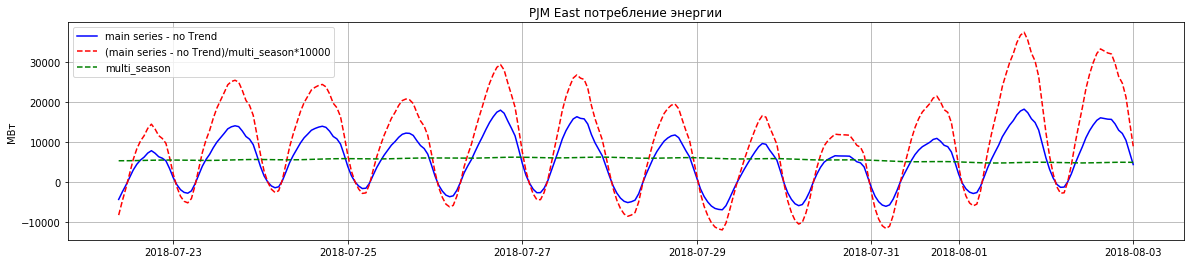

In [14]:
y_season=y_no_trend_no_season['no_season'].rolling(season_fm).mean()
y_season[np.where(np.abs(y_season)<np.mean(np.abs(y_season))*0.001)[0]]=np.mean(np.abs(y_season))
# запишем сезонную составляющую
y_no_trend_no_season['season'] = y_season
# сохраним остатки без сезона и тренда
y_no_trend_no_season['no_trend_no_season'] = y_no_trend_no_season['no_season']/y_season

y_no_trend_no_season['add_season'] =  y_no_trend_no_season['no_trend'].rolling(season).mean()



plt.figure(figsize =(20,4))

plt.plot( data.index[-280:],y_no_trend_no_season['no_season'][-280:], 'b' , label ='main series - no Trend')
plt.plot( data.index[-280:],y_no_trend_no_season['no_trend_no_season'][-280:]*10000 , '--r' , label ='(main series - no Trend)/multi_season*10000')
plt.plot( data.index[-280:],y_season[-280:], '--g' , label ='multi_season')


plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

In [15]:
y_no_trend_no_season.tail()

,no_trend,trend,no_season,season,no_trend_no_season,add_season
2018-08-02 20:00:00,13347.591311,33450.137406,12904.135352,4904.458406,2.631103,443.455960
2018-08-02 21:00:00,12546.600738,33450.146833,12102.460694,4906.357123,2.466690,444.140044
2018-08-02 22:00:00,10842.610165,33450.156260,10397.661950,4901.926141,2.121138,444.948215
2018-08-02 23:00:00,7790.619592,33450.165687,7344.879530,4889.839114,1.502070,445.740062
2018-08-03 00:00:00,4776.629019,33450.175113,4330.160694,4870.649667,0.889031,446.468324


Итак ряд состоит из:
 - тренд y1=y_no_trend_no_season['trend']
 - сезон y2=y_no_trend_no_season['season']
 - остатки y3=y_no_trend_no_season['no_trend_no_season']
 
 Ряд можно собрать назад:
 
 y3*y2+y1

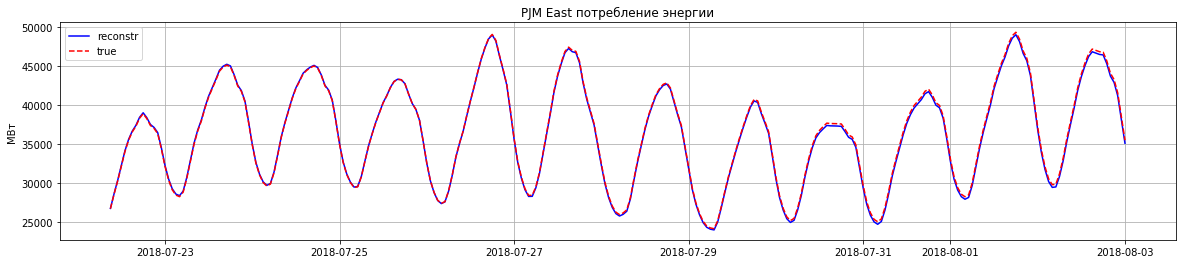

In [16]:
plt.figure(figsize =(20,4))
# 6*y_no_trend_no_season['add_season'][-280:]  - поправка на неаккуратные добавки -сделаные выше (при выделении сезона не учтена)
plt.plot( data.index[-280:],y_no_trend_no_season['season'][-280:]*y_no_trend_no_season['no_trend_no_season'][-280:]+y_no_trend_no_season['trend'][-280:]-6*y_no_trend_no_season['add_season'][-280:]  , 'b' , label ='reconstr')
plt.plot( data.index[-280:],data['PJME_MW'].iloc[-280:] , '--r' , label ='true')



plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

Обратная операция прошла штатно, т.е. собрали ряд обратно и можно строить модели по каждой части отдельно. 

Посмотрим на аномалии, и поищем их в ряду потребление энергии.



Наша цель лежит между 2012 и 2014 годом. Интуитивно понятно, что дело в уровне. Начнем с постановки задачи.

In [17]:
data.index = pd.to_datetime(data.index)
type(data['PJME_MW'])
data.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', length=145374, freq=None)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = data['PJME_MW']
dec = seasonal_decompose(ts, period = 6760)
trend = dec.trend
seasonal = dec.seasonal
residuals = dec.resid

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

TypeError: seasonal_decompose() got an unexpected keyword argument 'period'



## Задача обнаружения аномалий ##

Для заданного множества объектов необходимо получить множество-исключение. 

С точки зрения временных рядов мы получаем следующее представление:
- Х - вектор наблюдения состоит из измерений временного ряда, а его длина соответствует ширине окна анализа.
- отклонение статистической характеристики вектора от остальных векторов можно считать аномалией. 


Основные задачи:
1.  Задача  распознавания  аномалий,  вытекающих  из  контекста  наблюдаемого  процесса.
2.  Задача  выделения  аномальных  участков  и  дифференциация  аномалий  от  шумов.
3.  Задача  распознавания  аномалий  путем  сравнения  идеальных  и  реальных  процессов.


**Типы аномалий**

Если анализировать только случайную компоненту, то многие аномалии можно свести к одному из следующих случаев:

***Выброс в данных временного ряда.*** Существенное амплитудное изменение ряда на коротком интервале. Классическая задача - работает правило трех сигм, межквартильный размах и другие.

***Изменение характера (распределения) значений.*** Движения временного ряда, связанные с редко происходящими событиями, имеющие скачкообразный характер и меняющие тенденцию. Эту часть предсказывать без внешней информации затруднительно.

***Отклонение от «повседневного» (для данных с циклом)*** Сравниваем текущий период и несколько предыдущих и оцениваем разницу. 

**Основные подходы к поиску аномалий**

- ***Метод  скользящего  окна***.  Ряд  разбивается  на  участки  (окна). Поиск  аномальной  подпоследовательности  осуществляется  при  помощи  скольжения  окна  по  всему  ряду  с  шагом  меньшим  длины  окна  ( размер  окна  нужно подобрать в эксперименте или задать на основе опыта,  увеличение  размера и числа окон  быстро повышают  вычислительную  сложность  алгоритма).  Метод  является  самым  универсальным,  и  применим  для  любых  типов рядов.


- ***Кластеризация***. Строит группировки измерений. Нет  представления  о  точности  границ  аномалий, пропускает  незначительные  аномалии. Универсальный  метод  поиска  аномалий.


- ***Статистические  методы***.  Используют  критерии  для  проверки  гипотез  о  сходстве  или  различии  двух  выборок.  Корреляционный  анализ между частями ряда может  служить  для  анализа  аномальности.  Хорошо работает в задачах  поиска  аномалий  в  физических  процессах. Анализ путём поиска представителей, которые меньше подходят к остальному набору данных.  

- ***Обнаружение аномалий основанное на модели регрессии временного ряда***. Наложив модель на данные, можно спрогнозировать тенденции, а затем проверить, все ли показатели соответствуют им. Для этого нужно сравнить спрогнозированные и фактические показатели. Значительная разница укажет на отклонение или аномалию.

 
- ***Выявления аномалий с учителем***. Требует предоставления данных, помеченных как «нормальные» и «ненормальные», и использует обучение классификатора (выборка очень несбалансирована). 


Посмотрим как применить различные техники поиска аномалий к нашему ряду. Разберем ряд на вектора и определим параметры распределения.

## Оценим поведение ряда. 

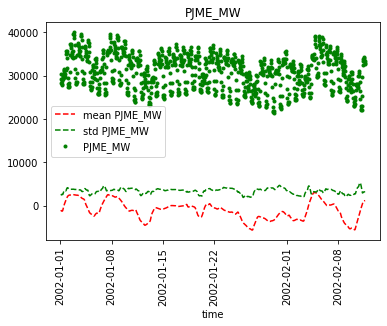

In [22]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1
mean_d=[]
std_d=[]

MeanT=np.mean(data['PJME_MW'])

for i in range(1000):
    d = data['PJME_MW'].iloc[i:i+w] - MeanT
    mean_d.append(np.mean(d))
    std_d.append(np.std(d))
plt.plot(data['data_time'].iloc[:1000],mean_d,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[:1000],std_d,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[:1000],data['PJME_MW'].iloc[:1000],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.legend()
plt.xlabel('time')
plt.xticks(rotation='90')
plt.show()

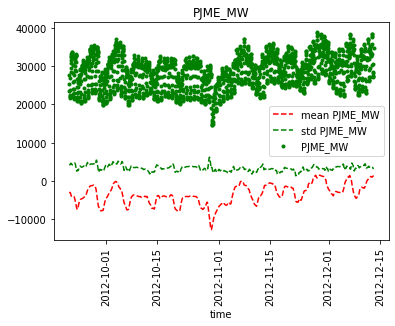

In [23]:
#размер окна  (в часах)
w = 24

#шаг окна  (в часах)
step_w= 1

T=24*365*11-24*100
mean_da=[]
std_da=[]
for i in range(2000):
    da = data['PJME_MW'].iloc[T+i:T+i+w] - MeanT
    mean_da.append(np.mean(da))
    std_da.append(np.std(da))
std_da = np.array(std_da)
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

На графике виден провал (ураган?). Кроме провала в основном ряду виден всплеск в ряду стандартных отклонений и провал в ряду средних. Можно построить простой тест: сглаживание - 1 день, D = |std_da[j]-mean[std_a]| > std_porog. Порог подберем по известной аномалии. В итоге получили метку для аномалии. Можем рассчитывать, что и другие аномалии найдем. Порог определен по разбросу стандартных отклонений ряда std_da (стандартное отклонение для стандартного отклонения), а коэффициент (80) результат подбора по известному факту аномалии.

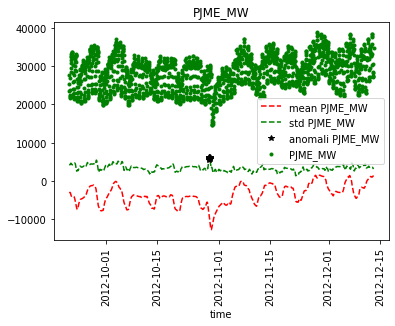

In [24]:

# порог - подобрали по известной аномалии
porog_ = np.abs(std_da - np.mean(std_da)) > (np.std(std_da)**0.5)*80
ind_ = np.where(porog_==1)[0]
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T][ind_],std_da[ind_],'*k',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Поиск аномалий подобным образом основан на прецедентах и может быть реализован как классификатор, если есть разметка. 

## Скользящее окно

Очевидно, что средняя во времени может изменяться. Таким образом имеет смысл смотреть на сглаженные модели ряда  или на скользящие средние, которые позволяют моделировать основные тенденции ряда, его сезонность(цикличность) с тем, чтобы увидеть истинные статистические характеристики конкретного отрезка ряда. Сделаем сглаживание по среднему на дневные интервалы и месячные циклы сезона.

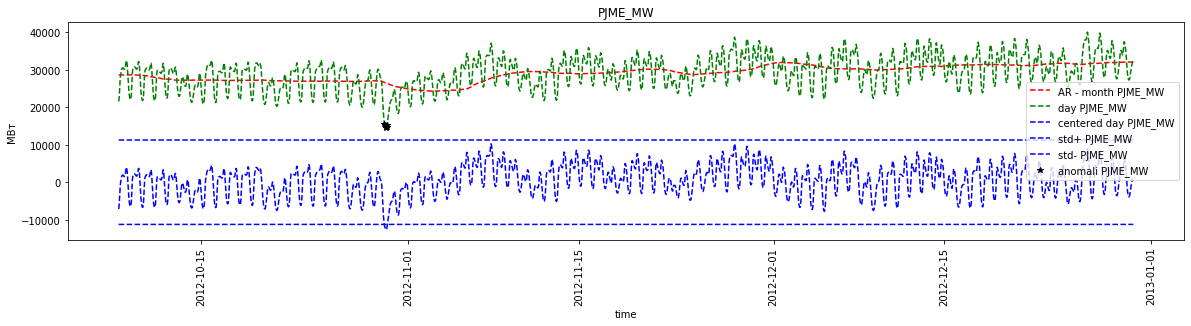

In [25]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1

data_m=data['PJME_MW'].rolling(w*30).mean()
diff_day = data['PJME_MW'].rolling(2).mean()#-data_m
data_d=data['PJME_MW'].rolling(w*7).mean()
#data_d[np.where(np.abs(data_d)<0.0001)[0]]=data_d.mean()
diff_day_month=diff_day-data_m
sigma3_diff_day_month = diff_day_month.std()*2

porog_ = np.abs(diff_day_month[-51000:-49000]) > sigma3_diff_day_month 
ind_ = np.where(porog_==1)[0]

plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'*k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()


## Кластеризация

Добавим ряду первые разности в набор данных и сделаем историческое описание размером p.

In [26]:

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()

from sklearn.cluster import KMeans, DBSCAN

In [27]:
data['stat'] = diff_day_month

p =3

#добавляем историю длиной р
for i in range(p):
    data['t'+str(p-i+1)]=0
    data['t'+str(p-i+1)].values[p+2:] = data['PJME_MW'].values[i+1:-(p-i+1)]
for i in range(p):
    data['d'+str(p-i+1)]=0    
    data['d'+str(p-i+1)].values[i+1:] = (data['PJME_MW'].values[i+1:]- data['PJME_MW'].values[i:-1])/data['PJME_MW'].values[i:-1]
data.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,data_time,stat,t4,t3,t2,d4,d3,d2
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0,2002-01-01 01:00:00,NaN,0,0,0,0,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0,2002-01-01 02:00:00,NaN,0,0,0,0,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0,2002-01-01 03:00:00,NaN,0,0,0,0,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0,2002-01-01 04:00:00,NaN,0,0,0,0,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0,2002-01-01 05:00:00,NaN,0,0,0,0,0,0
2002-01-01 06:00:00,28654.0,2002,1,1,1,1,1,1,6,1,0,0,2002-01-01 06:00:00,NaN,29265,28357,27899,0,0,0
2002-01-01 07:00:00,29308.0,2002,1,1,1,1,1,1,7,1,0,0,2002-01-01 07:00:00,NaN,28357,27899,28057,0,0,0
2002-01-01 08:00:00,29595.0,2002,1,1,1,1,1,1,8,1,0,0,2002-01-01 08:00:00,NaN,27899,28057,28654,0,0,0
2002-01-01 09:00:00,29943.0,2002,1,1,1,1,1,1,9,1,0,0,2002-01-01 09:00:00,NaN,28057,28654,29308,0,0,0
2002-01-01 10:00:00,30692.0,2002,1,1,1,1,1,1,10,1,0,0,2002-01-01 10:00:00,NaN,28654,29308,29595,0,0,0


In [28]:
X = data.drop(['data_time'],axis=1).iloc[p+2:,1:].values

In [29]:
Xscale = scl.fit_transform(X[-51000:-49000,:])

clast = DBSCAN(eps=1.0, leaf_size=5, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [ 0.         -1.34142074 -1.02932223  0.         -1.71979668 -1.59870342
 -1.50304942 -0.79509168  4.58017707 -0.19324699 -0.22454436 -1.67785329
 -1.76512351 -1.86448388 -1.85858705  0.          0.          0.        ]
Число кластеров с масштабированием:  19
Число не кластеров:  7


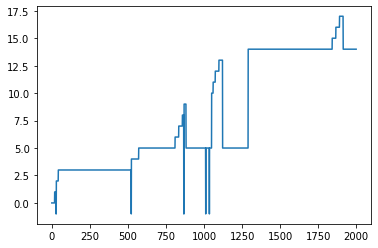

In [30]:
# не шум, но кластер со смыслом
ind_c= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_c[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

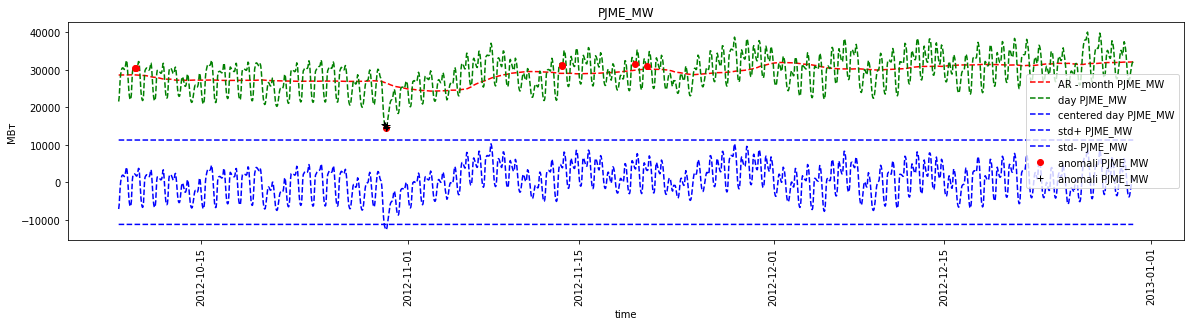

In [31]:
ind_anomal_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_c = np.array(ind_anomal_c)+p+2  


plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_anomal_c],diff_day[-51000:-49000].values[ind_anomal_c],'or',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'+k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()


Добавили анализ по кластерам к анализу по статистике скользящих окон и видим совпадение точки для 30.10.2012. Можно расчитывать на то, что это аномалия. Однако проверим еще раз используя модель ряда.

In [32]:


data_week=data['PJME_MW'].resample("W").apply('mean')

np.where(data_week.index.weekofyear == pd.to_datetime('2012-10-30').weekofyear)[0]

array([ 43,  95, 147, 200, 252, 304, 356, 408, 461, 513, 565, 617, 669,
       721, 774, 826])

Сделаем ресемплинг, для ускорения работы модели на недельные отсчеты. Построим модель ряда по ARIMA (опираясь на результаты урока 2)

In [33]:


mod = sm.tsa.statespace.SARIMAX(data_week.values[200:560],order=[0,0,0],
                                seasonal_order=[2,0,0,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)



AIC:{} 4722.690984524124


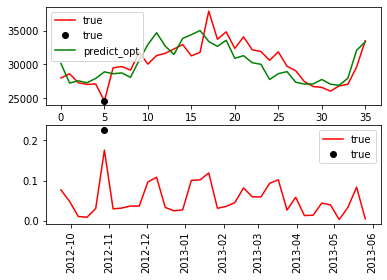

In [34]:
data_month = data_week.copy()  
pred_dynamic_opt = results_opt.forecast(12*3)
plt.subplot(2,1,1)
plt.plot( data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( 5,data_month.values[565], 'ok',label='true' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.legend()
plt.subplot(2,1,2)

plt.plot( data_month.index[560-1:560+12*3-1],np.abs(data_month.values[560:560+12*3]-pred_dynamic_opt)/data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( data_month.index[565-1],np.abs(data_month.values[565]-pred_dynamic_opt[0])/data_month.values[565], 'ok',label='true' )
plt.xticks(rotation='90')
plt.legend()
plt.show()

Видно, что аномалия 2012.10.30 лежит на уровне больших ошибок. Это позволяет ее с хорошей вероятностью считать аномалией поведения ряда (на других участках ряда эта модель дает примерно одинаковые ошибки, а тут видим значительное возрастание ошибки на отрезке до 1 месяца). Таким образом подтверждена проблема ряда 30.10.2012.


Замечание:
Визуальный анализ и анализ уровней выявляет аномалию амплитуды, однако не выявит аномалии частотного типа. Для этого следует перейти не к статистикам ряда, а к методам частотного анализа (спектральным моделям анализа ряда, например).

**КАК ИСПОЛЬЗОВАТЬ АНОМАЛИИ:**
 - Построить набор примеров для классификации следующих аномалий.
 - Проверить модель на следующих интервалах, вдруг это не аномалия.

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [35]:

path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

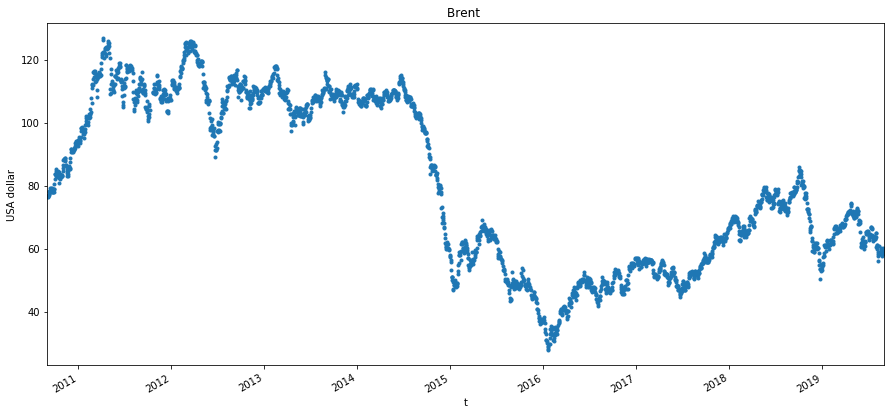

In [36]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Помним, что наиболее интересным для и интерпретируемым у этого ряда является поведение его первых разностей
Построим их и посмотрим на аномалии этой части нашей модели.

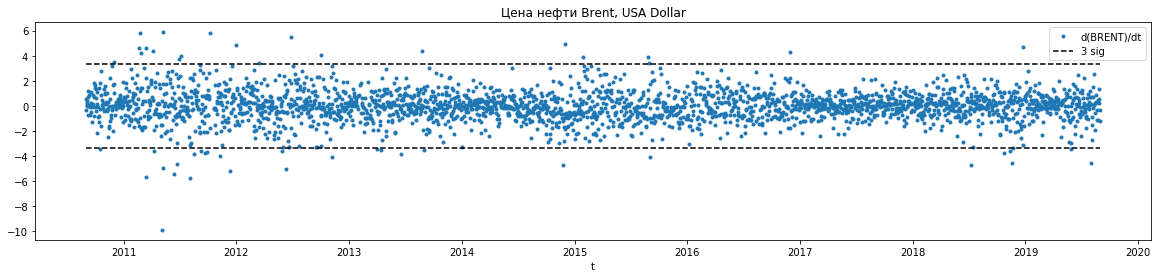

In [37]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
s_brent = np.std(d_brent_data)**0.5 *3
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]



Рис.4 BRENT первые разности

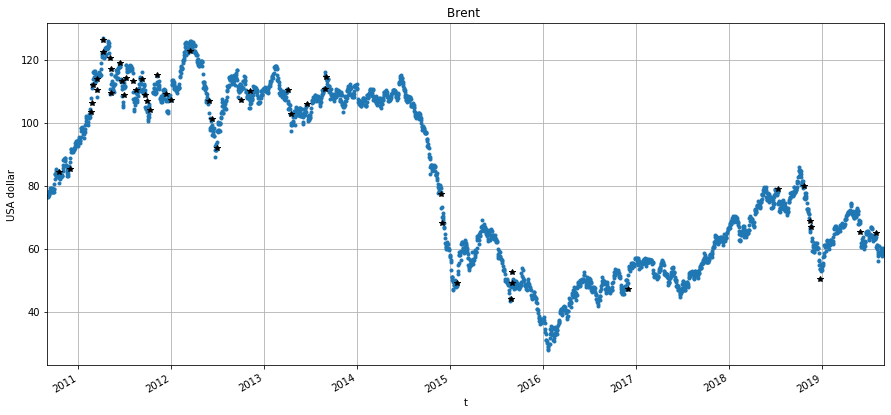

In [38]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'*k', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t')
plt.show()

In [39]:
brent_data['Значение'].values[:-1]

array([76.37, 76.89, 76.57, ..., 59.84, 60.37, 59.19])

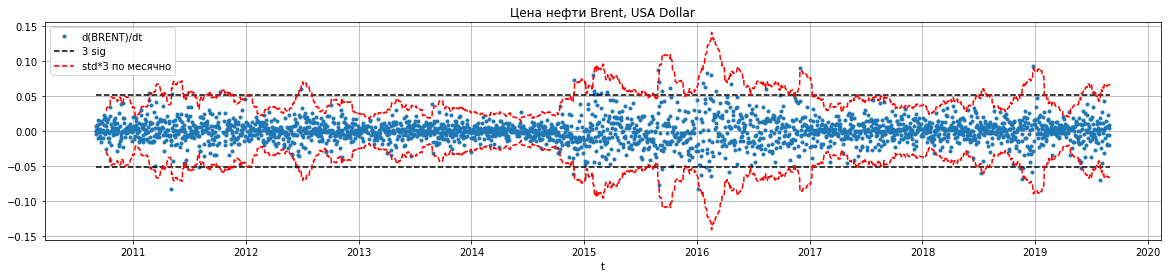

In [40]:
d_brent_data1 = (brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1])/brent_data['Значение'].values[:-1]
std_d_brent = pd.DataFrame(data=d_brent_data1,index =brent_data.index[1:] ).rolling(30).std()
s_brent1 = np.std(d_brent_data1)*3 
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(std_d_brent.index,std_d_brent*3,'--r',label = 'std*3 по месячно')
plt.plot(std_d_brent.index,-std_d_brent*3,'--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent1 = np.where( abs(d_brent_data1)>s_brent1)[0]
ind_anomal_brent2 = np.where( abs(d_brent_data1)>std_d_brent.values)[0]

In [41]:
brent_data.index[[0,-1]]

DatetimeIndex(['2010-09-01', '2019-09-01'], dtype='datetime64[ns]', name='Дата', freq=None)

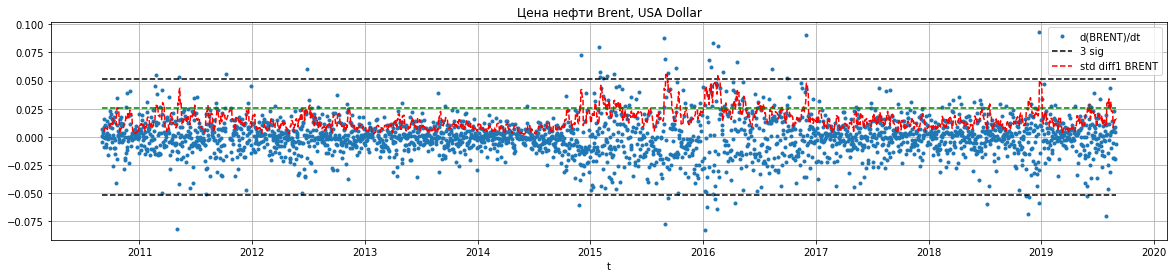

In [42]:
brent_diff1=pd.DataFrame(data=d_brent_data1, index=brent_data.index[1:])

brent_diff1_std=brent_diff1[0].rolling(7).std()
brent_diff_std=np.std(brent_diff1_std)*3

ind_anomal_brent2 = np.where( abs(brent_diff1_std)>brent_diff_std)[0]

plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(brent_diff1_std,'--r',label ='std diff1 BRENT')
plt.plot(brent_diff1_std.iloc[[0,-1]].index,[brent_diff_std,brent_diff_std],'--g')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()


In [43]:
brent_diff_std

0.02527901110956135

In [44]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0    
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))


In [45]:

X = brent_data.iloc[p+2:,:].values

Xscale = scl.fit_transform(X)

clast = DBSCAN(eps=2.9, leaf_size=1, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)


первый элемент кластера 0  :  [-0.17721153 -1.75698575  0.72500659 -1.11065221  0.44539858  0.63193593
  0.63776124 -1.33798808  5.91379514 -0.16553715 -0.17488451 -0.19246036
 -0.19219421 -0.19194461  0.00947192  0.00947192  0.00947192]
Число кластеров с масштабированием:  8
Число не кластеров:  20


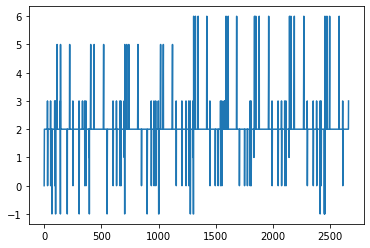

In [46]:
# не шум, но кластер со смыслом
ind_= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

Text(0.5, 0, 't')

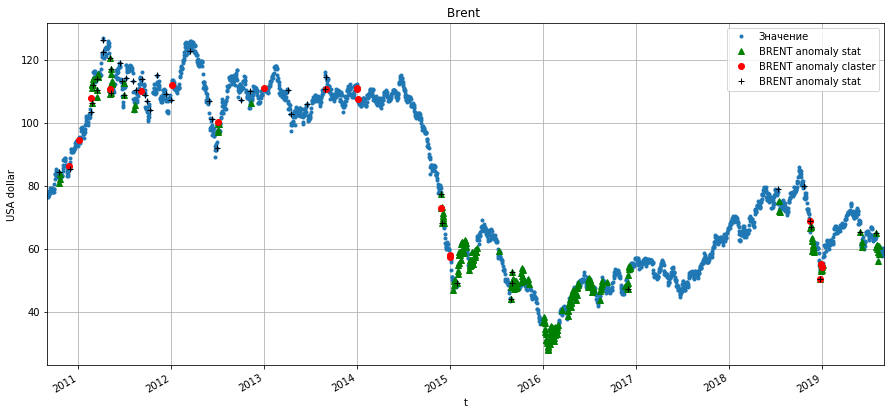

In [47]:
ind_anomal_brent_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_brent_c = np.array(ind_anomal_brent_c)+p+2  

_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent2].index,brent_data['Значение'].values[ind_anomal_brent2],'^g', label='BRENT anomaly stat')
plt.plot(brent_data.iloc[ind_anomal_brent_c].index,brent_data['Значение'].values[ind_anomal_brent_c],'or', label='BRENT anomaly claster')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'+k', label='BRENT anomaly stat')
plt.legend()
plt.grid()
plt.ylabel('USA dollar')
plt.xlabel('t')


Построили несколько кандидатов на аномальное поведение. Попробуем определить какой-нибудь дополнительный способ анализа.

## Генерация признаков  из внешних источников

Естественным попутчиком любого финансово -ориентированного ряда является кросс-курс валют. В случае BRENT патриотично рассматриваем кросс-курс доллар-рубль (стоимость доллара в рублях) и евро-рубль (стоимость евро в рублях). Интервал измерения стоимости доллара и евро соответствует частоте и периоду нашего ряда "стоимость нефти", а источник данных https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=01.09.2010&UniDbQuery.ToDate=01.09.2019, который позволяет сохранить результаты в нескольких различных вариантах. Прочитаем, сохраненные данные.

In [48]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

FileNotFoundError: [Errno 2] No such file or directory: 'RC_F01_09_2010_T01_09_2019.xlsx'

In [ ]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

И сделаем их визуализацию.

In [ ]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Посмотрим на первые разности. Помним, что для BRENT первые разности стационарны. Проверим как выглядят они для кросс-курсов.

In [ ]:
d_rub_doll = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

   


Сопоставим списки результатов, которые вышли за границы 3 сигма.

In [ ]:
ind_anomal_brent

In [ ]:
ind_anomal_rubl_d

In [ ]:
ind_anomal_rubl_e

Есть пересечение всех трех множеств объект с номером 1335. Покажем этот и несколько соседних объектов (они сильно выпадают из ряда у кросс-курсов): 

In [ ]:
rub_doll.index[[1333, 1334, 1335, 1336, 1337]]

Проблема кросс-курса с рублем в том, что трудно сказать курс зависит от цены  нефти или цена от курса (но по логике экономики должен курс рубля зависеть от цены нефти). 2016 в январе курс к доллару составил 82 р (https://www.gazeta.ru/business/2016/01/20/8031815.shtml) на фоне резкого падения цены нефти (иранский фактор - сняли эмбарго на экспорт в начале января). Однако, если в некоторый день цена нефти и кросс-курс ведут себя разнонаправленно, то можно предположить. что это не глобальное явление, а некоторый случайный выброс. Декабрь 2015-январь 2016 - смена уровня , т.е. глобальное изменение ряда по типу аномалии "изменение характера (распределения) значений". В данном случае сильно изменяется средняя ряда.

Добавим стоимость валюты в рублях

In [ ]:
brent_data['doll']=0
brent_data['doll'].values[1:2229]=rub_doll['curs'].values[:]
brent_data=brent_data.iloc[:2229,:]

В итоге данные примут вид 

In [ ]:
brent_data.iloc[100:115,:]


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [ ]:
scl_target=StandardScaler() 

h=1
target = brent_data["Значение"].values[h:].reshape((brent_data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

In [ ]:
scl_x=StandardScaler() 

X = brent_data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки 1 , 7, 11, 12, 13 и 17. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [ ]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

Лучшее множество признаков отделенов X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [ ]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

Наконец, третий вариант - применим выделение признаков через построение модели . Помним , что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [ ]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

Сравним результаты:


In [ ]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

In [ ]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,14,21] признаки и перейдем к построению модели.

In [ ]:
X_new = X[:,[0,11,12,13,17]]


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [ ]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 100 от конца

In [ ]:
train, test = split_data( brent_data[-2000:], -100)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [ ]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [ ]:
train.shape

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Все модели возьмем в варианте параметров по умолчанию.

In [49]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)
model_l = LinearRegression()

Запускаем модели и смотрим , что они построят на наших примерах.

In [50]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

NameError: name 'X_train' is not defined

**Посмотрим тесты**

In [51]:
X_test.shape

NameError: name 'X_test' is not defined

In [52]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

NameError: name 'X_train' is not defined

NameError: name 'y_test_pred_g' is not defined

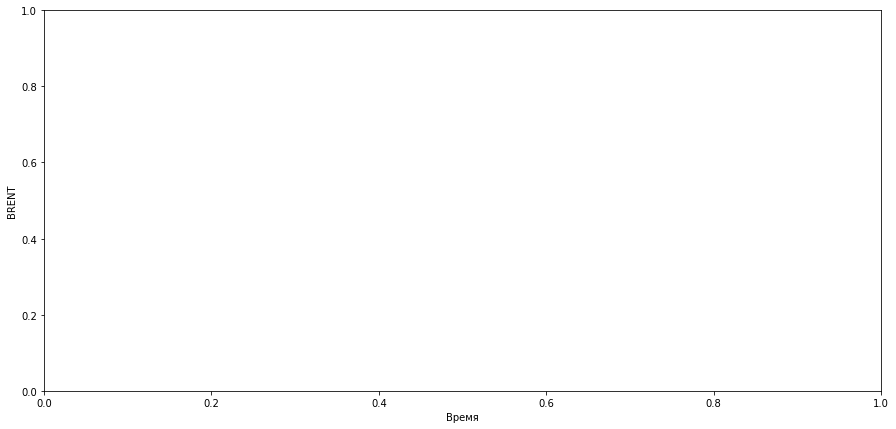

In [53]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g[:100],'or', label='predict GB data' )
plt.plot(y_test_pred_g[:100],'r' )
plt.plot(y_test_pred_l[:100], label='predict Linear data' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

NameError: name 'y_pred_g' is not defined

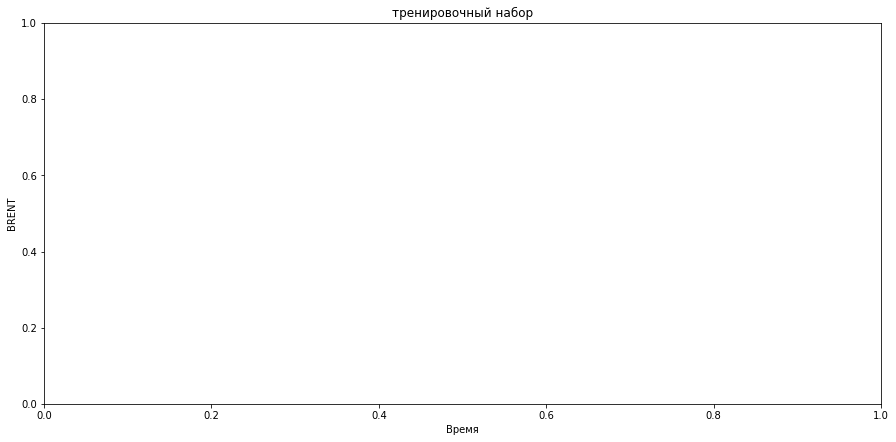

In [54]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_pred_l[-100:], label='predict Linear data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()

Линейная модель практически не работает, т.к. видно запаздывание в размере h.Градиентный бустинг практически не отличается от нее на интервале обучения. Посмотрим на оценки.

**Оценки для сравнения моделей**

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [56]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

NameError: name 'y_test' is not defined

Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [58]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

NameError: name 'scl_target' is not defined

In [59]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

NameError: name 'X_train' is not defined

In [ ]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

In [ ]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

## Сохранение модели

In [ ]:
import pickle
# save the model to disk
filename = 'final_model_brent.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_brent_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_brent_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Следим за аномалиями



## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю (можно добавить и сами курсы валют - прошлые значения)
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

### Ссылки

https://arxiv.org/pdf/2002.04236.pdf 

https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest

https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest